**<h1>Auto Regressive Model and some helper Functions ** 

In [1]:
import numpy as np
from scipy import io
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.preprocessing import normalize
from sklearn.svm import OneClassSVM
from matplotlib.pyplot import figure

In [2]:
def load_data(path):
    data = io.loadmat(path)
    return data['dataset']

In [3]:
def plot_signal(data,channel_no,test_no):
    plt.plot(data[:,channel_no,test_no])
    plt.xlabel('Time Step')
    plt.ylabel('Accelaration')

In [4]:
def fit_AR(test):
    model = AR(test)
    model_fit = model.fit()
    return model_fit

In [5]:
def plot_ar_parameters(params):
    plt.plot(params)
    plt.xlabel('Parameter Number')
    plt.ylabel('Parameter Value')

In [6]:
def get_model_order(data):
    model_fit = fit_AR(data[:,1,1])
    return model_fit.k_ar+1

In [7]:
def get_params(fitted_model):
    return fitted_model.params

In [8]:
def comparative_ARParameter_plot(test1,test2,test3,test4):
    t1 = data[:,4,test1]
    t2 = data[:,4,test2]
    t3 = data[:,4,test3]
    t4 = data[:,3,test4]
    param1 = get_params(fit_AR(t1))
    param2 = get_params(fit_AR(t2))
    param3 = get_params(fit_AR(t3))
    param4 = get_params(fit_AR(t4))
    x = [i for i in range(len(param1))]
    plt.plot(x,param1,'-o')
    plt.plot(x,param2,'-o')
    plt.plot(x,param3,'-o')
    plt.plot(x,param4,'-o')
    plt.xlabel('Feature Number')
    plt.ylabel('Auto Regressive Feature Value')

<h1>Building The Test and Train Matrix

In [9]:
def build_train_matrix(data,end_test_number,start_channel_number,end_channel_number):
    X = [] #test_matrix
    for i in range(end_test_number):
        order = get_model_order(data)
        avg_feature_over_channels = np.zeros(order)
        for j in range(start_channel_number,end_channel_number):
            model_fit = fit_AR(data[:,j,i])
            params = get_params(model_fit)
            avg_feature_over_channels+=params
        a = avg_feature_over_channels.shape[0]
        avg_feature_over_channels/=(end_channel_number-start_channel_number)
        avg_feature_over_channels.reshape(a,1)
        X.append(avg_feature_over_channels)
    X = np.array(X)
    X = normalize(X,axis=1)
    return X

In [10]:
def build_test_matrix(data,start,end,start_channel,end_channel):
	T = []
	for i in range(start,end):
		order = get_model_order(data)
		avg_feature_over_channels = np.zeros(order)
		for j in range(start_channel,end_channel):
			model_fit = fit_AR(data[:,j,i])
			params = get_params(model_fit)
			avg_feature_over_channels+=params
		avg_feature_over_channels/=(end_channel-start_channel)
		a = avg_feature_over_channels.shape[0]
		avg_feature_over_channels.reshape(a,1)
		T.append(avg_feature_over_channels)
	T = np.array(T)
	T = normalize(T,axis=1)
	return T

**<h1>Visualisations of the data**

In [11]:
data = load_data('/home/rishav/shm_machineLearning/data3SS.mat')

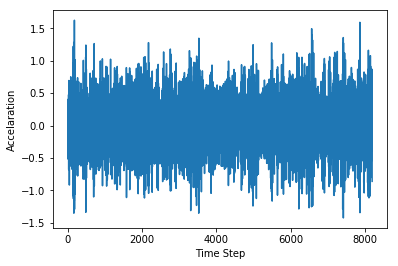

In [12]:
plot_signal(data,4,4)

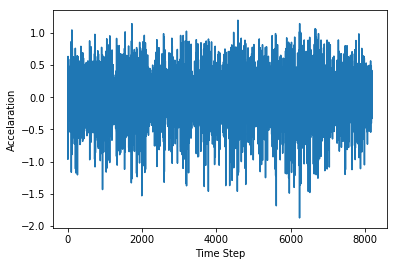

In [13]:
plot_signal(data,4,842)

In [15]:
p = get_model_order(data)
print(p)

37


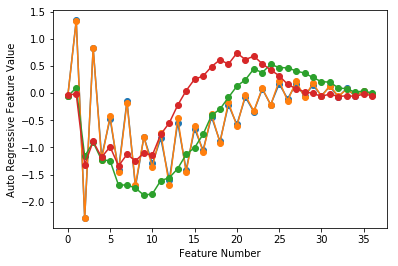

In [16]:
comparative_ARParameter_plot(1,10,600,815)

<h1> Test and train matrices built

In [31]:
X = build_train_matrix(data,450,1,5)
Z = build_test_matrix(data,450,850,1,5)

<h1> One Class SVM and helper fucntions

In [59]:
def SVMOneClass(X):
    clf = OneClassSVM(gamma=0.025,nu=0.8)
    fit = clf.fit(X)
    return fit

In [34]:
def get_Support_Vectors(fitted_model):
    return fitted_model.support_vectors_

In [35]:
def get_DIs(support_vectors,matrix):
    mu = np.mean(support_vectors,axis=0)
    cov_inv = np.linalg.inv(np.cov(support_vectors.T))
    DI = []
    for i in range(len(matrix)):
        temp = np.log((((matrix[i]-mu).T).dot(cov_inv)).dot(matrix[i]-mu)) #mahalanobis distance
        DI.append(temp)
    DI = np.array(DI)
    return DI

In [36]:
def getConfidenceInterval(DI):
    return [-2*np.std(DI) + np.mean(DI),2*np.std(DI) + np.mean(DI)]

In [37]:
def concat(DI_undamaged,DI_damaged):
    return np.concatenate((DI_undamaged,DI_damaged))

In [38]:
def plot_characteristics(DI,interval):
    figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
    y = [i for i in range(len(DI))]
    plt.scatter(y,DI)
    plt.hlines(interval[0],0,850,'r')
    plt.hlines(interval[1],0,850,'r')
    plt.xlabel("Test Number")
    plt.ylabel("log(DI)")
    plt.vlines(450,2,10)
    i = 500
    while i<=850:
        plt.vlines(i,2,10,'g')
        i+=50
    plt.show()

In [44]:
def type1(DI_undamaged,interval):
    error = 0
    for item in DI_undamaged:
        if (item<interval[0] or item>interval[1]):
            error+=1
    return error

In [45]:
def type2(DI_damaged,interval):
    error = 0
    for item in DI_damaged:
        if(item<interval[1]):
            error+=1
    return error

<h1> Running one class SVM, obtaining plot and errors

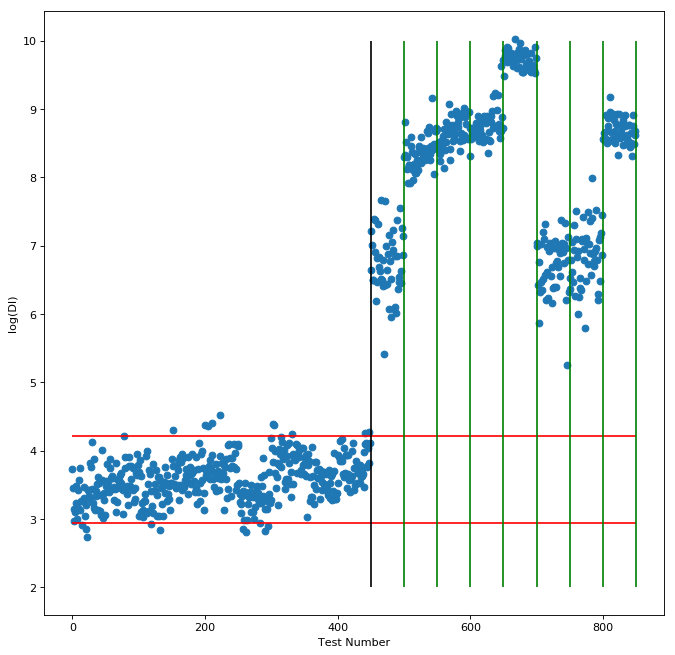

In [60]:
fitted_model = SVMOneClass(X)
support_vectors = get_Support_Vectors(fitted_model)
DI_undamaged = get_DIs(support_vectors,X)
DI_damaged = get_DIs(support_vectors,Z)
interval = getConfidenceInterval(DI_undamaged)
DI = concat(DI_undamaged,DI_damaged)
plot_characteristics(DI,interval)

<h1>Error Calculation

In [61]:
type1_error = type1(DI_undamaged,interval)
type2_error = type2(DI_damaged,interval)
print("type1-error %f"%((type1_error*100)/len(DI_undamaged)))
print("type2-error %f"%((type2_error*100)/len(DI_damaged)))
print("total-error %f"%(((type1_error+type2_error)*100)/len(DI)))

type1-error 4.444444
type2-error 0.000000
total-error 2.352941
